In [1]:
!pip install torchinfo

In [2]:
from google.colab import drive

In [3]:
import os
import sys
from collections import Counter
from torch.utils.data import Dataset
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import json
import zipfile
from google.colab import drive
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, log_loss
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import copy
from tqdm.notebook import tqdm
import matplotlib.image as mpimg
torch.backends.cudnn.deterministic = True

In [4]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: linux
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
---
matplotlib version: 3.10.0
pandas version: 2.2.2
PIL version: 11.2.1
torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [5]:
# Check if GPUs available via `cuda`
cuda_gpus_available = torch.cuda.is_available()

# Check if GPUs available via `mps`
mps_gpus_available = torch.backends.mps.is_available()

print("cuda GPUs available:", cuda_gpus_available)
print("mps GPUs available:", mps_gpus_available)

device = torch.device("cuda" if cuda_gpus_available==True else "cpu")
print("Using:", device)

BATCH_SIZE = 32
RANDOM_SEED = 42


cuda GPUs available: True
mps GPUs available: False
Using: cuda


In [6]:
drive.mount('/content/drive')
drive_root = "/content/drive/MyDrive"
project_dir = os.path.join(drive_root, "Wildlife_Tai_National_Park")
os.makedirs(project_dir, exist_ok=True)

Mounted at /content/drive


In [7]:
zip_path = os.path.join(drive_root, "datasets/competition_VfIpjyh.zip")
extract_dir = "/content/dataset"

if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
print("Dataset extracted to:", extract_dir)

Dataset extracted to: /content/dataset


In [8]:
data_dir = "dataset"
train_df = pd.read_csv(os.path.join(data_dir, "train_features.csv"), index_col="id")
test_df = pd.read_csv(os.path.join(data_dir, "test_features.csv"), index_col="id")
label_df = pd.read_csv(os.path.join(data_dir, "train_labels.csv"), index_col="id")


In [9]:
species_labels = list(label_df.columns)
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

array([[[45, 45, 45],
        [43, 43, 43],
        [41, 41, 41],
        ...,
        [43, 43, 43],
        [43, 43, 43],
        [38, 38, 38]],

       [[61, 61, 61],
        [58, 58, 58],
        [56, 56, 56],
        ...,
        [58, 58, 58],
        [60, 60, 60],
        [55, 55, 55]],

       [[60, 60, 60],
        [57, 57, 57],
        [56, 56, 56],
        ...,
        [63, 63, 63],
        [65, 65, 65],
        [61, 61, 61]],

       ...,

       [[48, 48, 48],
        [48, 48, 48],
        [48, 48, 48],
        ...,
        [48, 48, 48],
        [50, 50, 50],
        [51, 51, 51]],

       [[45, 45, 45],
        [45, 45, 45],
        [45, 45, 45],
        ...,
        [50, 50, 50],
        [49, 49, 49],
        [48, 48, 48]],

       [[44, 44, 44],
        [44, 44, 44],
        [44, 44, 44],
        ...,
        [51, 51, 51],
        [48, 48, 48],
        [46, 46, 46]]], dtype=uint8)
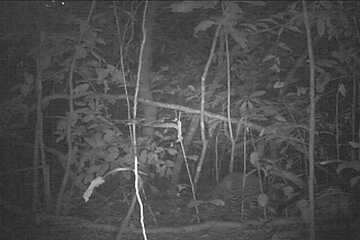

In [10]:
sample_img= cv2.imread("dataset/train_features/ZJ000042.jpg")
sample_img

In [11]:
train_df.head()

,filepath,site
id,,
ZJ000000,train_features/ZJ000000.jpg,S0120
ZJ000001,train_features/ZJ000001.jpg,S0069
ZJ000002,train_features/ZJ000002.jpg,S0009
ZJ000003,train_features/ZJ000003.jpg,S0008
ZJ000004,train_features/ZJ000004.jpg,S0036


In [12]:
test_df.head()

,filepath,site
id,,
ZJ016488,test_features/ZJ016488.jpg,S0082
ZJ016489,test_features/ZJ016489.jpg,S0040
ZJ016490,test_features/ZJ016490.jpg,S0040
ZJ016491,test_features/ZJ016491.jpg,S0041
ZJ016492,test_features/ZJ016492.jpg,S0040


In [13]:
label_df.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


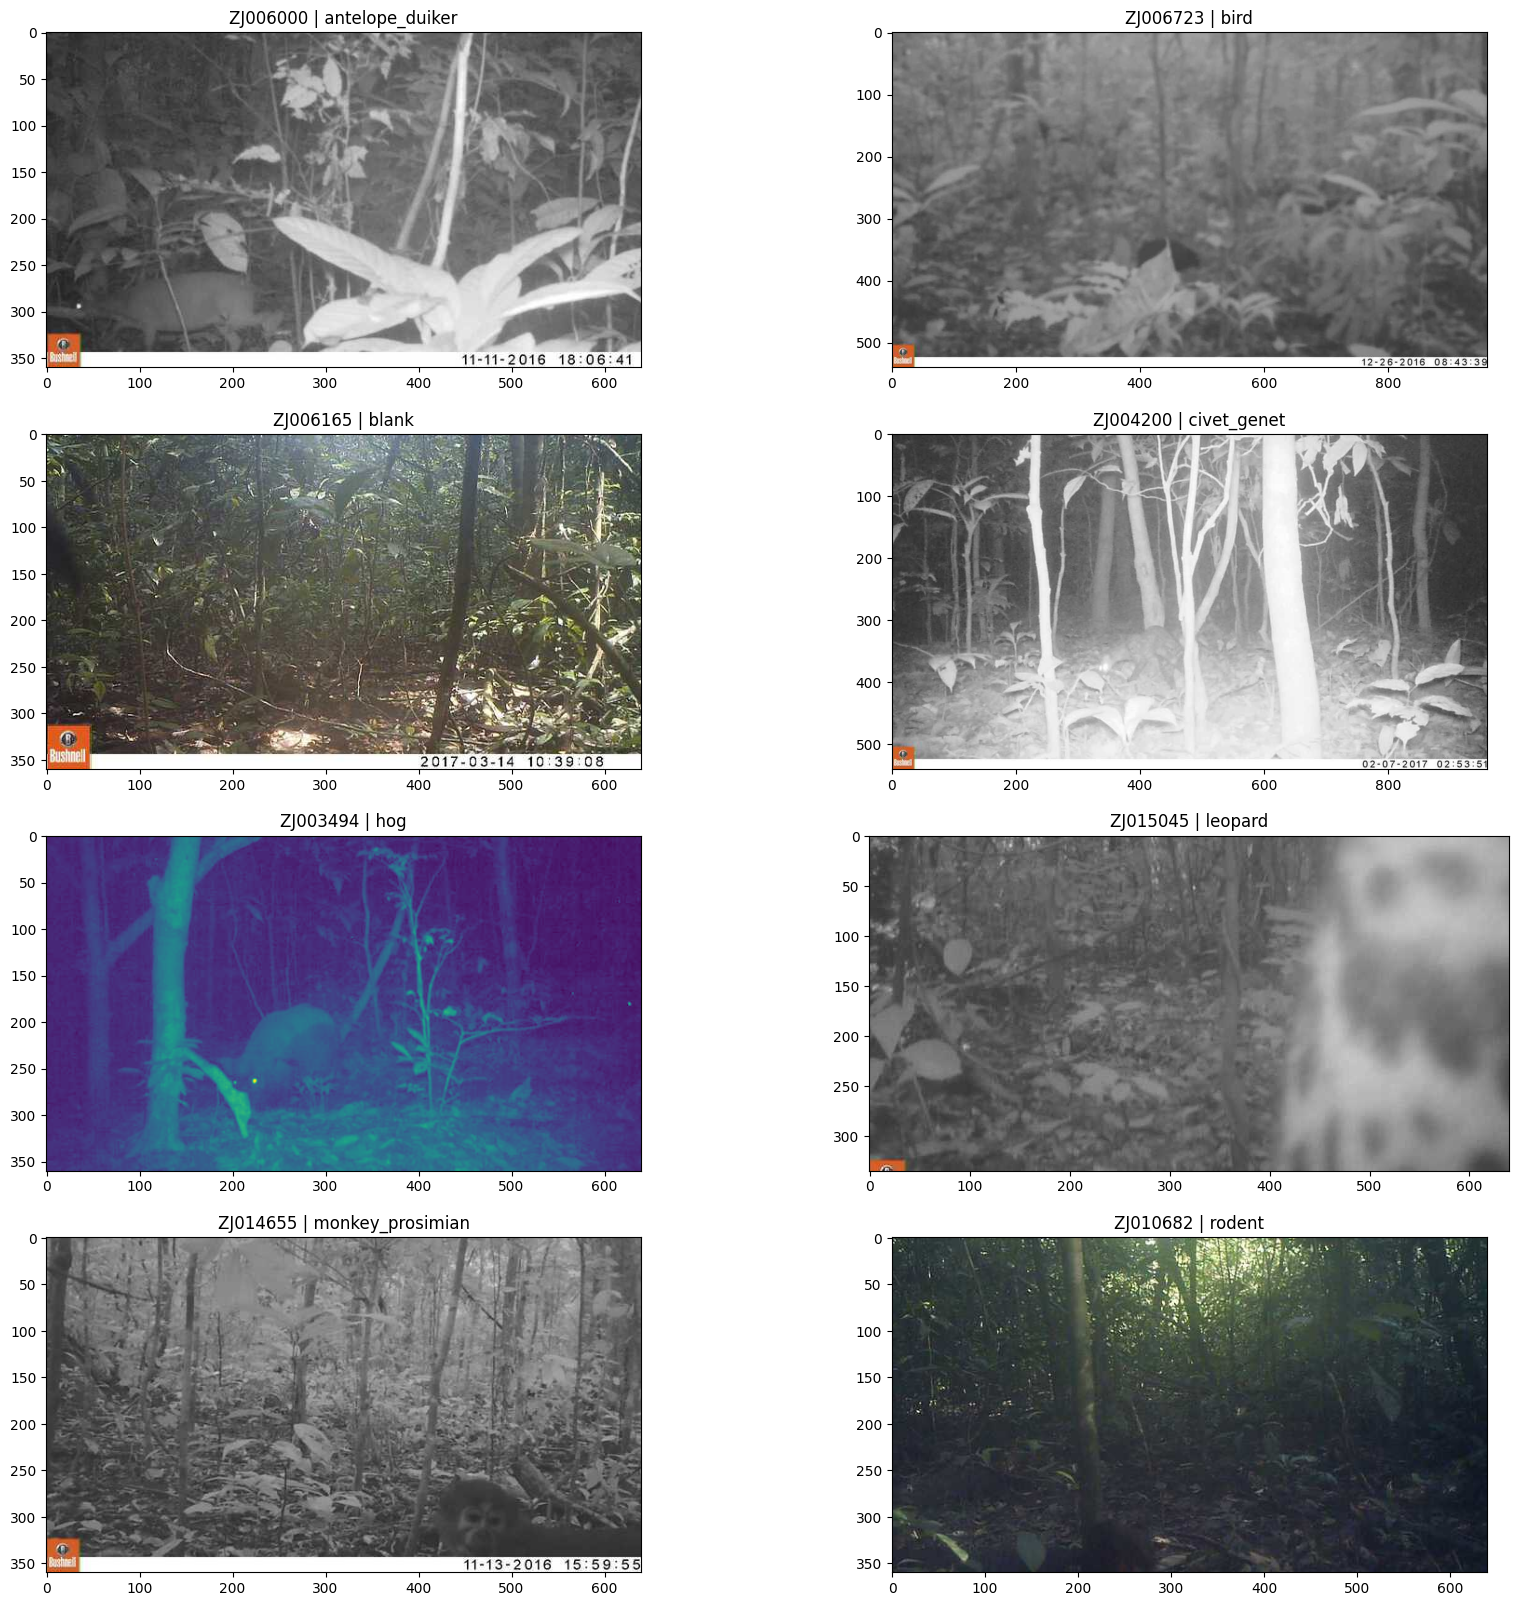

In [14]:
random_state = 42

# we'll create a grid with 8 positions, one for each label (7 species, plus blanks)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        label_df[label_df.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = mpimg.imread(f"/content/dataset/{train_df.loc[img_id].filepath}")
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")

In [15]:
label_df.sum().sort_values(ascending=False)

,0
monkey_prosimian,2492.0
antelope_duiker,2474.0
civet_genet,2423.0
leopard,2254.0
blank,2213.0
rodent,2013.0
bird,1641.0
hog,978.0


In [16]:
label_df.sum().sort_values(ascending=False)/len(label_df)

,0
monkey_prosimian,0.151140
antelope_duiker,0.150049
civet_genet,0.146955
leopard,0.136705
blank,0.134219
rodent,0.122089
bird,0.099527
hog,0.059316


In [17]:
class WildlifeDataset(Dataset):
    def __init__(self, df_x, df_y=None, base_path="dataset", transform=None):
        self.df_x = df_x
        self.df_y = df_y
        self.base_path = base_path
        self.transform = transform

    def __len__(self):
        return len(self.df_x)

    def __getitem__(self, idx):
        image_id = self.df_x.index[idx]
        image_path = os.path.join(self.base_path, self.df_x.loc[image_id, "filepath"])
        image = PIL.Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        if self.df_y is not None:
            label = torch.tensor(self.df_y.loc[image_id].values.argmax(), dtype=torch.long)
            return image, label
        else:
            return image, image_id

In [18]:
def compute_mean_std(loader):
    channels_sum, channels_squared, num_batches = 0, 0, 0
    for images, _ in tqdm(loader, desc="Calculating mean/std"):
        channels_sum += torch.mean(images, dim=[0, 2, 3])
        channels_squared += torch.mean(images ** 2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared / num_batches - mean ** 2) ** 0.5
    return mean, std

stats_path = os.path.join(project_dir, "dataset_stats.json")

def is_valid_json(path):
    try:
        with open(path, "r") as f:
            json.load(f)
        return True
    except Exception as e:
        print(f"⚠️ Warning: Invalid JSON at {path}: {e}")
        return False

resize_then_tensor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dummy_ds = WildlifeDataset(train_df, label_df, transform=resize_then_tensor)
dummy_loader = DataLoader(dummy_ds, batch_size=32)

# ✅ Safe loading with fallback
if os.path.exists(stats_path) and is_valid_json(stats_path):
    with open(stats_path, "r") as f:
        stats = json.load(f)
    mean = torch.tensor(stats["mean"])
    std = torch.tensor(stats["std"])
    print("✅ Loaded dataset stats from Drive.")
    print("Mean:", mean)
    print("Std:", std)
else:
    print("🔁 Computing mean/std from scratch...")
    mean, std = compute_mean_std(dummy_loader)
    with open(stats_path, "w") as f:
        json.dump({"mean": mean.tolist(), "std": std.tolist()}, f)
    print("✅ Saved new dataset stats.")
    print("Mean:", mean)
    print("Std:", std)

✅ Loaded dataset stats from Drive.
Mean: tensor([0.4787, 0.4925, 0.4833])
Std: tensor([0.2541, 0.2470, 0.2501])


In [19]:
# 🏋️‍♂️ Augmented Transform for Training
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

# 📏 Clean Transform for Validation / Test
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

In [20]:
x_train, x_val, y_train, y_val = train_test_split(
    train_df, label_df, test_size=0.2, stratify=label_df.values.argmax(1), random_state=RANDOM_SEED)

train_ds = WildlifeDataset(x_train, y_train, transform=train_transform)
val_ds = WildlifeDataset(x_val, y_val, transform=val_test_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle =False)

In [21]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64 * 28 * 28, 500),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(500, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CustomCNN(num_classes=len(species_labels)).to(device)


In [22]:
summary(model)

Layer (type:depth-idx)                   Param #
CustomCNN                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       448
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       4,640
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       18,496
│    └─ReLU: 2-8                         --
│    └─MaxPool2d: 2-9                    --
├─Sequential: 1-2                        --
│    └─Flatten: 2-10                     --
│    └─Dropout: 2-11                     --
│    └─Linear: 2-12                      25,088,500
│    └─ReLU: 2-13                        --
│    └─Dropout: 2-14                     --
│    └─Linear: 2-15                      4,008
Total params: 25,116,092
Trainable params: 25,116,092
Non-trainable params: 0

In [23]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters())
print(criterion)
print("----------------------")
print(optimizer)
print("----------------------")
print(next(model.parameters()).device)

CrossEntropyLoss()
----------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
----------------------
cuda:0


In [24]:
def train_model(
    model,
    train_loader,
    val_loader,
    epochs,
    patience=5,
    grad_clip=1.0,
    save_path="best_model.pth"
):
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "lr": []
    }

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_counter = 0

    # Optimizer and Scheduler
    optimizer = optim.Adam(model.parameters())
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # 🔒 Gradient Clipping
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        # 🔍 Validation
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = outputs.argmax(1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct_val / total_val

        # 🔁 Scheduler Step
        scheduler.step(avg_val_loss)

        # 📊 Logging
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["lr"].append(scheduler.get_last_lr()[0])


        print(
            f"\n📅 Epoch {epoch+1} | "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}"
        )

        # ✅ Early Stopping + Checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            patience_counter = 0
            print("🧠 Best model saved.")
        else:
            patience_counter += 1
            print(f"⚠️ No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("⏹️ Early stopping triggered!")
            break

    model.load_state_dict(best_model_wts)
    return model, history

In [25]:
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(15, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Learning Rate
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["lr"], label="Learning Rate", color="orange")
    plt.title("Learning Rate Schedule")
    plt.xlabel("Epochs")
    plt.ylabel("LR")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [26]:
EPOCHS= 25
PATIENCE=4

🔁 Resuming CustomCNN...


[Train] Epoch 1/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 1 | Train Loss: 1.1967, Train Acc: 0.6784 | Val Loss: 1.0736, Val Acc: 0.7317 | LR: 0.001000
🧠 Best model saved.


[Train] Epoch 2/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 2 | Train Loss: 1.1930, Train Acc: 0.6806 | Val Loss: 1.0522, Val Acc: 0.7423 | LR: 0.001000
🧠 Best model saved.


[Train] Epoch 3/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 3 | Train Loss: 1.1954, Train Acc: 0.6776 | Val Loss: 1.0619, Val Acc: 0.7414 | LR: 0.001000
⚠️ No improvement. Patience: 1/4


[Train] Epoch 4/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 4 | Train Loss: 1.1866, Train Acc: 0.6804 | Val Loss: 1.0711, Val Acc: 0.7368 | LR: 0.001000
⚠️ No improvement. Patience: 2/4


[Train] Epoch 5/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 5 | Train Loss: 1.1803, Train Acc: 0.6835 | Val Loss: 1.0623, Val Acc: 0.7401 | LR: 0.000500
⚠️ No improvement. Patience: 3/4


[Train] Epoch 6/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 6 | Train Loss: 1.1559, Train Acc: 0.6968 | Val Loss: 1.0270, Val Acc: 0.7495 | LR: 0.000500
🧠 Best model saved.


[Train] Epoch 7/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 7 | Train Loss: 1.1431, Train Acc: 0.7094 | Val Loss: 1.0272, Val Acc: 0.7547 | LR: 0.000500
⚠️ No improvement. Patience: 1/4


[Train] Epoch 8/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 8 | Train Loss: 1.1354, Train Acc: 0.7098 | Val Loss: 1.0389, Val Acc: 0.7505 | LR: 0.000500
⚠️ No improvement. Patience: 2/4


[Train] Epoch 9/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 9 | Train Loss: 1.1331, Train Acc: 0.7078 | Val Loss: 1.0236, Val Acc: 0.7592 | LR: 0.000500
🧠 Best model saved.


[Train] Epoch 10/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 10 | Train Loss: 1.1399, Train Acc: 0.7092 | Val Loss: 1.0160, Val Acc: 0.7605 | LR: 0.000500
🧠 Best model saved.


[Train] Epoch 11/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 11 | Train Loss: 1.1346, Train Acc: 0.7108 | Val Loss: 1.0307, Val Acc: 0.7544 | LR: 0.000500
⚠️ No improvement. Patience: 1/4


[Train] Epoch 12/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 12 | Train Loss: 1.1303, Train Acc: 0.7044 | Val Loss: 1.0166, Val Acc: 0.7638 | LR: 0.000500
⚠️ No improvement. Patience: 2/4


[Train] Epoch 13/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 13 | Train Loss: 1.1213, Train Acc: 0.7134 | Val Loss: 1.0237, Val Acc: 0.7617 | LR: 0.000250
⚠️ No improvement. Patience: 3/4


[Train] Epoch 14/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 14 | Train Loss: 1.1075, Train Acc: 0.7215 | Val Loss: 1.0123, Val Acc: 0.7656 | LR: 0.000250
🧠 Best model saved.


[Train] Epoch 15/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 15 | Train Loss: 1.1084, Train Acc: 0.7168 | Val Loss: 1.0120, Val Acc: 0.7680 | LR: 0.000250
🧠 Best model saved.


[Train] Epoch 16/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 16 | Train Loss: 1.1006, Train Acc: 0.7281 | Val Loss: 1.0070, Val Acc: 0.7708 | LR: 0.000250
🧠 Best model saved.


[Train] Epoch 17/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 17 | Train Loss: 1.1022, Train Acc: 0.7273 | Val Loss: 1.0037, Val Acc: 0.7650 | LR: 0.000250
🧠 Best model saved.


[Train] Epoch 18/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 18 | Train Loss: 1.0974, Train Acc: 0.7247 | Val Loss: 0.9969, Val Acc: 0.7699 | LR: 0.000250
🧠 Best model saved.


[Train] Epoch 19/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 19 | Train Loss: 1.0999, Train Acc: 0.7274 | Val Loss: 0.9968, Val Acc: 0.7705 | LR: 0.000250
🧠 Best model saved.


[Train] Epoch 20/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 20 | Train Loss: 1.0885, Train Acc: 0.7266 | Val Loss: 1.0003, Val Acc: 0.7662 | LR: 0.000250
⚠️ No improvement. Patience: 1/4


[Train] Epoch 21/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 21 | Train Loss: 1.0874, Train Acc: 0.7288 | Val Loss: 0.9954, Val Acc: 0.7732 | LR: 0.000250
🧠 Best model saved.


[Train] Epoch 22/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 22 | Train Loss: 1.0866, Train Acc: 0.7291 | Val Loss: 0.9968, Val Acc: 0.7756 | LR: 0.000250
⚠️ No improvement. Patience: 1/4


[Train] Epoch 23/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 23 | Train Loss: 1.0861, Train Acc: 0.7309 | Val Loss: 0.9944, Val Acc: 0.7747 | LR: 0.000250
🧠 Best model saved.


[Train] Epoch 24/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 24 | Train Loss: 1.0839, Train Acc: 0.7302 | Val Loss: 0.9967, Val Acc: 0.7723 | LR: 0.000250
⚠️ No improvement. Patience: 1/4


[Train] Epoch 25/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 25 | Train Loss: 1.0886, Train Acc: 0.7301 | Val Loss: 0.9919, Val Acc: 0.7741 | LR: 0.000250
🧠 Best model saved.


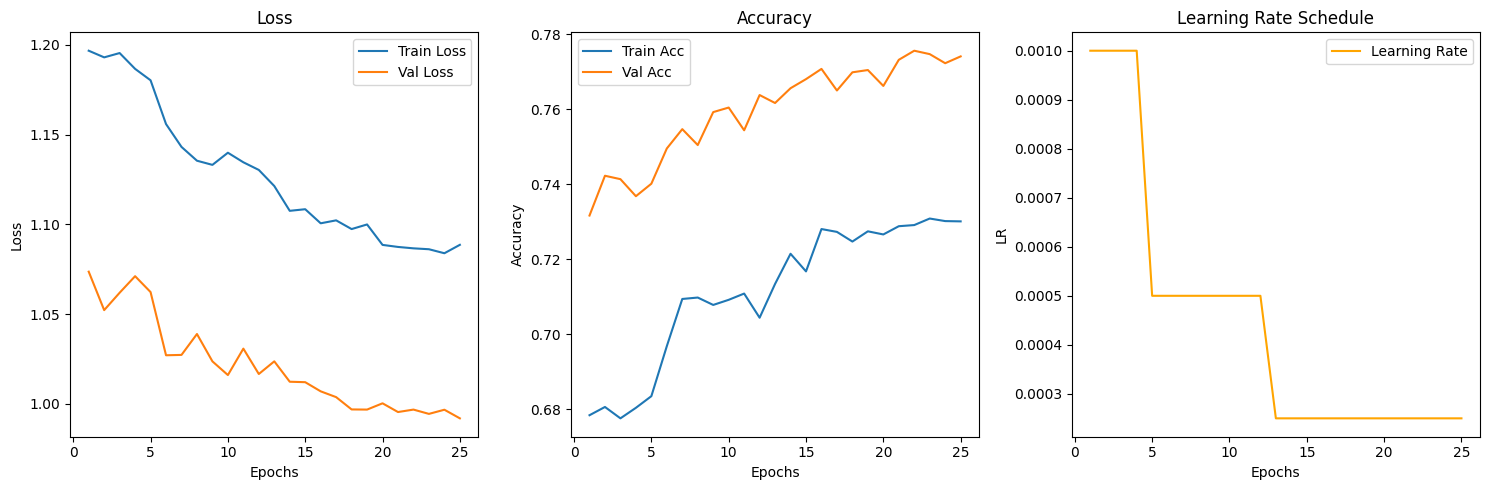

In [27]:
cnn_model_path = os.path.join(project_dir, "best_model_customcnn.pth")
model = CustomCNN(num_classes=len(species_labels)).to(device)

if os.path.exists(cnn_model_path):
    print("🔁 Resuming CustomCNN...")
    model.load_state_dict(torch.load(cnn_model_path))

model, history = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    patience=PATIENCE,
    grad_clip=1.0,
    save_path=cnn_model_path
)

plot_history(history)


In [28]:
def evaluate_model(model, val_loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total
    print(f"🧪 Val Loss: {avg_loss:.4f}, Val Accuracy: {accuracy:.4f}")

    return all_preds, all_labels


In [29]:
all_preds, all_labels = evaluate_model(model, val_loader)


🧪 Val Loss: 0.9919, Val Accuracy: 0.7741


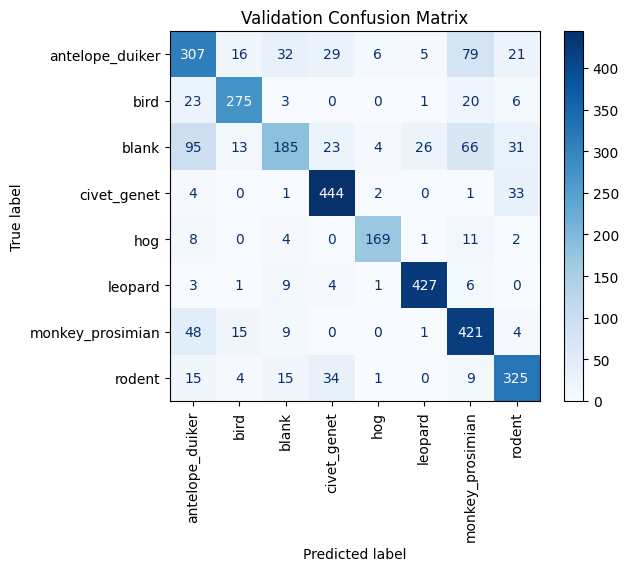

In [30]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=species_labels)
disp.plot(xticks_rotation=90, cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

In [31]:
def get_val_probs(model, val_loader, temperature=1.0):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs / temperature, dim=1)
            all_probs.append(probs.cpu())
            all_labels.append(labels)

    return torch.cat(all_probs), torch.cat(all_labels)

In [32]:
cnn_val_probs, val_targets = get_val_probs(model, val_loader)

In [33]:
cnn_loss = log_loss(val_targets.numpy(), cnn_val_probs.numpy())
print(f"CNN Log Loss: {cnn_loss:.4f}")

CNN Log Loss: 0.6918


In [ ]:
resnet_model_path = os.path.join(project_dir, "best_model_resnet.pth")
resnet_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

for name, param in resnet_model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 8)

resnet_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(resnet_model.parameters())
print(criterion)
print("----------------------")
print(optimizer)
print("----------------------")
print(next(resnet_model.parameters()).device)

CrossEntropyLoss()
----------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
----------------------
cuda:0


In [ ]:
def train_resnet_model(
    model,
    train_loader,
    val_loader,
    epochs,
    patience=5,
    grad_clip=1.0,
    save_path = "best_model_resnet.pth"
):
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "lr": []
    }

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_counter = 0

    # Optimizer and Scheduler
    optimizer = torch.optim.Adam(resnet_model.parameters())
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # 🔒 Gradient Clipping
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        # 🔍 Validation
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = outputs.argmax(1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct_val / total_val

        # 🔁 Scheduler Step
        scheduler.step(avg_val_loss)

        # 📊 Logging
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["lr"].append(scheduler.get_last_lr()[0])


        print(
            f"\n📅 Epoch {epoch+1} | "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}"
        )

        # ✅ Early Stopping + Checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            patience_counter = 0
            print("🧠 Best model saved.")
        else:
            patience_counter += 1
            print(f"⚠️ No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("⏹️ Early stopping triggered!")
            break

    model.load_state_dict(best_model_wts)
    return model, history

🔁 Resuming ResNet50...


[Train] Epoch 1/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 1 | Train Loss: 0.6628, Train Acc: 0.9240 | Val Loss: 0.7896, Val Acc: 0.8760 | LR: 0.001000
🧠 Best model saved.


[Train] Epoch 2/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 2 | Train Loss: 0.6588, Train Acc: 0.9255 | Val Loss: 0.7802, Val Acc: 0.8745 | LR: 0.001000
🧠 Best model saved.


[Train] Epoch 3/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 3 | Train Loss: 0.6532, Train Acc: 0.9262 | Val Loss: 0.7579, Val Acc: 0.8839 | LR: 0.001000
🧠 Best model saved.


[Train] Epoch 4/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 4 | Train Loss: 0.6523, Train Acc: 0.9268 | Val Loss: 0.7559, Val Acc: 0.8851 | LR: 0.001000
🧠 Best model saved.


[Train] Epoch 5/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 5 | Train Loss: 0.6474, Train Acc: 0.9307 | Val Loss: 0.7499, Val Acc: 0.8887 | LR: 0.001000
🧠 Best model saved.


[Train] Epoch 6/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 6 | Train Loss: 0.6418, Train Acc: 0.9344 | Val Loss: 0.7623, Val Acc: 0.8899 | LR: 0.001000
⚠️ No improvement. Patience: 1/4


[Train] Epoch 7/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 7 | Train Loss: 0.6420, Train Acc: 0.9325 | Val Loss: 0.7521, Val Acc: 0.8887 | LR: 0.001000
⚠️ No improvement. Patience: 2/4


[Train] Epoch 8/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 8 | Train Loss: 0.6339, Train Acc: 0.9369 | Val Loss: 0.7479, Val Acc: 0.8875 | LR: 0.001000
🧠 Best model saved.


[Train] Epoch 9/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 9 | Train Loss: 0.6361, Train Acc: 0.9336 | Val Loss: 0.7631, Val Acc: 0.8890 | LR: 0.001000
⚠️ No improvement. Patience: 1/4


[Train] Epoch 10/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 10 | Train Loss: 0.6298, Train Acc: 0.9375 | Val Loss: 0.7555, Val Acc: 0.8884 | LR: 0.001000
⚠️ No improvement. Patience: 2/4


[Train] Epoch 11/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 11 | Train Loss: 0.6324, Train Acc: 0.9370 | Val Loss: 0.7628, Val Acc: 0.8896 | LR: 0.000500
⚠️ No improvement. Patience: 3/4


[Train] Epoch 12/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 12 | Train Loss: 0.6049, Train Acc: 0.9480 | Val Loss: 0.7426, Val Acc: 0.8924 | LR: 0.000500
🧠 Best model saved.


[Train] Epoch 13/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 13 | Train Loss: 0.5977, Train Acc: 0.9520 | Val Loss: 0.7311, Val Acc: 0.8933 | LR: 0.000500
🧠 Best model saved.


[Train] Epoch 14/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 14 | Train Loss: 0.5885, Train Acc: 0.9556 | Val Loss: 0.7418, Val Acc: 0.8948 | LR: 0.000500
⚠️ No improvement. Patience: 1/4


[Train] Epoch 15/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 15 | Train Loss: 0.5881, Train Acc: 0.9550 | Val Loss: 0.7292, Val Acc: 0.9002 | LR: 0.000500
🧠 Best model saved.


[Train] Epoch 16/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 16 | Train Loss: 0.5838, Train Acc: 0.9573 | Val Loss: 0.7372, Val Acc: 0.8954 | LR: 0.000500
⚠️ No improvement. Patience: 1/4


[Train] Epoch 17/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 17 | Train Loss: 0.5804, Train Acc: 0.9607 | Val Loss: 0.7298, Val Acc: 0.8975 | LR: 0.000500
⚠️ No improvement. Patience: 2/4


[Train] Epoch 18/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 18 | Train Loss: 0.5823, Train Acc: 0.9576 | Val Loss: 0.7311, Val Acc: 0.8951 | LR: 0.000250
⚠️ No improvement. Patience: 3/4


[Train] Epoch 19/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 19 | Train Loss: 0.5714, Train Acc: 0.9631 | Val Loss: 0.7213, Val Acc: 0.9018 | LR: 0.000250
🧠 Best model saved.


[Train] Epoch 20/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 20 | Train Loss: 0.5699, Train Acc: 0.9625 | Val Loss: 0.7151, Val Acc: 0.9033 | LR: 0.000250
🧠 Best model saved.


[Train] Epoch 21/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 21 | Train Loss: 0.5672, Train Acc: 0.9650 | Val Loss: 0.7196, Val Acc: 0.9054 | LR: 0.000250
⚠️ No improvement. Patience: 1/4


[Train] Epoch 22/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 22 | Train Loss: 0.5658, Train Acc: 0.9640 | Val Loss: 0.7256, Val Acc: 0.8990 | LR: 0.000250
⚠️ No improvement. Patience: 2/4


[Train] Epoch 23/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 23 | Train Loss: 0.5623, Train Acc: 0.9665 | Val Loss: 0.7220, Val Acc: 0.9051 | LR: 0.000125
⚠️ No improvement. Patience: 3/4


[Train] Epoch 24/25:   0%|          | 0/413 [00:00<?, ?it/s]


📅 Epoch 24 | Train Loss: 0.5576, Train Acc: 0.9685 | Val Loss: 0.7177, Val Acc: 0.9036 | LR: 0.000125
⚠️ No improvement. Patience: 4/4
⏹️ Early stopping triggered!


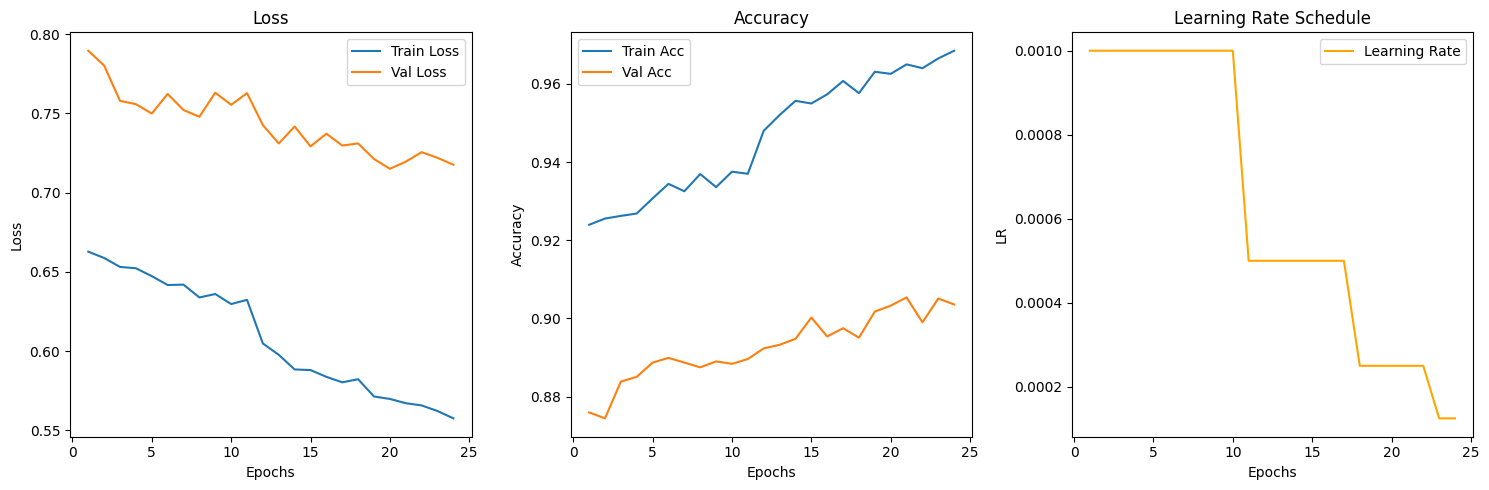

In [37]:
if os.path.exists(resnet_model_path):
    print("🔁 Resuming ResNet50...")
    resnet_model.load_state_dict(torch.load(resnet_model_path))

resnet_model, history = train_resnet_model(
    model=resnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    patience=PATIENCE,
    grad_clip=1.0,
    save_path=resnet_model_path
)

plot_history(history)


In [38]:
all_preds, all_labels = evaluate_model(resnet_model, val_loader)


🧪 Val Loss: 0.7151, Val Accuracy: 0.9033


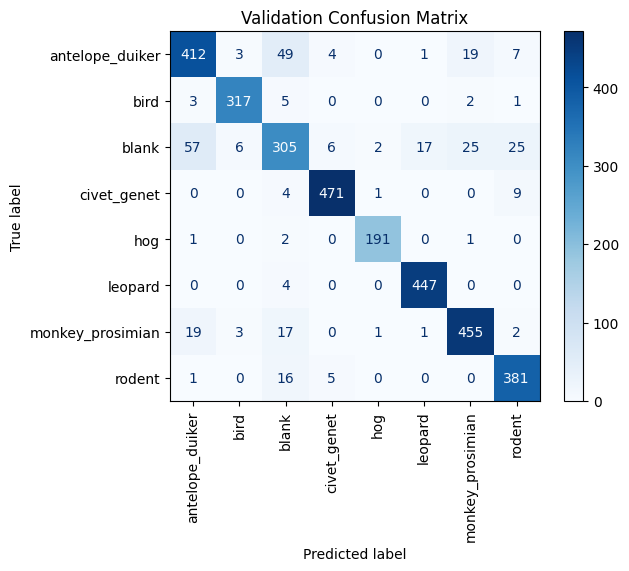

In [39]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=species_labels)
disp.plot(xticks_rotation=90, cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

In [40]:
resnet_val_probs, _ = get_val_probs(resnet_model, val_loader)
resnet_loss = log_loss(val_targets.numpy(), resnet_val_probs.numpy())
print(f"Resnet Model Log Loss: {resnet_loss}")

Resnet Model Log Loss: 0.3686315912673046


In [41]:
test_dataset = WildlifeDataset(test_df, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=32)
temperature=1

In [42]:
cnn_model_path

'/content/drive/MyDrive/Wildlife_Tai_National_Park/best_model_customcnn.pth'

In [43]:
cnn_model = CustomCNN(num_classes=len(species_labels)).to(device)

if os.path.exists(cnn_model_path):
    print("🔁 Loading trained CustomCNN...")
    cnn_model.load_state_dict(torch.load(cnn_model_path))
cnn_model.eval()

# Predict with CNN
cnn_preds_collector = []

with torch.no_grad():
    for images, image_ids in tqdm(test_loader, desc="🧪 CNN Test Prediction"):
        images = images.to(device)
        outputs = cnn_model(images)
        probs = F.softmax(outputs / temperature, dim=1)

        preds_df = pd.DataFrame(
            probs.cpu().numpy(),
            index=image_ids,
            columns=species_labels
        )
        cnn_preds_collector.append(preds_df)

cnn_submission_df = pd.concat(cnn_preds_collector)
cnn_submission_df = cnn_submission_df.loc[test_df.index]
cnn_submission_df.index.name = "id"

cnn_submission_path = os.path.join(project_dir, "submission_cnn.csv")
cnn_submission_df.to_csv(cnn_submission_path)
print(f"✅ CNN Submission saved to: {cnn_submission_path}")

🔁 Loading trained CustomCNN...


🧪 CNN Test Prediction:   0%|          | 0/140 [00:00<?, ?it/s]

✅ CNN Submission saved to: /content/drive/MyDrive/Wildlife_Tai_National_Park/submission_cnn.csv


In [44]:
if os.path.exists(resnet_model_path):
    print("🔁 Loading Resnet50 pretrained model...")
    resnet_model.load_state_dict(torch.load(resnet_model_path))
resnet_model.eval()

# Predict with RESNET50
resnet_preds_collector = []

with torch.no_grad():
    for images, image_ids in tqdm(test_loader, desc="🧪 Test Prediction"):
        images = images.to(device)
        outputs = resnet_model(images)
        # probs = F.softmax(outputs, dim=1)
        probs = F.softmax(outputs / temperature, dim=1)

        preds_df = pd.DataFrame(
            probs.cpu().numpy(),
            index=image_ids,
            columns=species_labels
        )
        resnet_preds_collector.append(preds_df)

resnet_submission_df = pd.concat(resnet_preds_collector)
resnet_submission_df = resnet_submission_df.loc[test_df.index]
resnet_submission_df.index.name = "id"

resnet_submission_path = os.path.join(project_dir, "submission_resnet.csv")
resnet_submission_df.to_csv(resnet_submission_path)
print(f"✅ Resnet Submission saved to: {resnet_submission_path}")

🔁 Loading Resnet50 pretrained model...


🧪 Test Prediction:   0%|          | 0/140 [00:00<?, ?it/s]

✅ Resnet Submission saved to: /content/drive/MyDrive/Wildlife_Tai_National_Park/submission_resnet.csv


In [45]:
def get_val_probs(model, val_loader, temperature=1.0):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs / temperature, dim=1)
            all_probs.append(probs.cpu())
            all_labels.append(labels)

    return torch.cat(all_probs), torch.cat(all_labels)


In [46]:
def tune_ensemble_weights(val_probs_list, val_labels, step=0.1):
    """
    val_probs_list: list of [model1_probs, model2_probs, ...]
    val_labels: true labels as integers
    """
    best_loss = float('inf')
    best_weights = None
    best_probs = None

    n_models = len(val_probs_list)
    weights_grid = np.arange(0, 1 + step, step)

    # Simple 2D grid search
    for w in weights_grid:
        weights = [w, 1 - w]
        combined = sum(w * p.numpy() for w, p in zip(weights, val_probs_list))
        loss = log_loss(val_labels.numpy(), combined)

        print(f"🔍 Weights: {weights} | Log Loss: {loss:.4f}")

        if loss < best_loss:
            best_loss = loss
            best_weights = weights
            best_probs = combined

    print(f"\n✅ Best Weights: {best_weights} | Log Loss: {best_loss:.4f}")
    return best_weights, best_probs

In [47]:
weights, _ = tune_ensemble_weights([cnn_val_probs, resnet_val_probs], val_targets)

🔍 Weights: [np.float64(0.0), np.float64(1.0)] | Log Loss: 0.3686
🔍 Weights: [np.float64(0.1), np.float64(0.9)] | Log Loss: 0.3730
🔍 Weights: [np.float64(0.2), np.float64(0.8)] | Log Loss: 0.3873
🔍 Weights: [np.float64(0.30000000000000004), np.float64(0.7)] | Log Loss: 0.4063
🔍 Weights: [np.float64(0.4), np.float64(0.6)] | Log Loss: 0.4292
🔍 Weights: [np.float64(0.5), np.float64(0.5)] | Log Loss: 0.4560
🔍 Weights: [np.float64(0.6000000000000001), np.float64(0.3999999999999999)] | Log Loss: 0.4870
🔍 Weights: [np.float64(0.7000000000000001), np.float64(0.29999999999999993)] | Log Loss: 0.5232
🔍 Weights: [np.float64(0.8), np.float64(0.19999999999999996)] | Log Loss: 0.5661
🔍 Weights: [np.float64(0.9), np.float64(0.09999999999999998)] | Log Loss: 0.6191
🔍 Weights: [np.float64(1.0), np.float64(0.0)] | Log Loss: 0.6918

✅ Best Weights: [np.float64(0.0), np.float64(1.0)] | Log Loss: 0.3686


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: T

In [48]:
ensemble_df = weights[0] * cnn_submission_df + weights[1] * resnet_submission_df
ensemble_df = ensemble_df.loc[test_df.index]
ensemble_df.index.name = "id"

submission_path = os.path.join(project_dir, "submission_ensemble.csv")
ensemble_df.to_csv(submission_path)
print(f"✅ Ensemble submission saved to: {submission_path}")


✅ Ensemble submission saved to: /content/drive/MyDrive/Wildlife_Tai_National_Park/submission_ensemble.csv
